# Применение бертоподобных моделей к задаче классификации

In [ ]:
!pip install -q -U watermark

In [ ]:
!pip install transformers

In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

In [4]:
import transformers
from transformers import BertModel, AutoTokenizer, BertTokenizer, PreTrainedTokenizerFast, AdamW, get_linear_schedule_with_warmup
import torch.nn.functional as F

import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 8, 6

In [6]:
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
100% 7.17M/7.17M [00:00<00:00, 49.6MB/s]


In [7]:
df = pd.read_csv("reviews.csv")

In [8]:
df.shape

(15746, 11)

In [9]:
from google.colab import data_table
data_table.disable_dataframe_formatter()

In [10]:
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


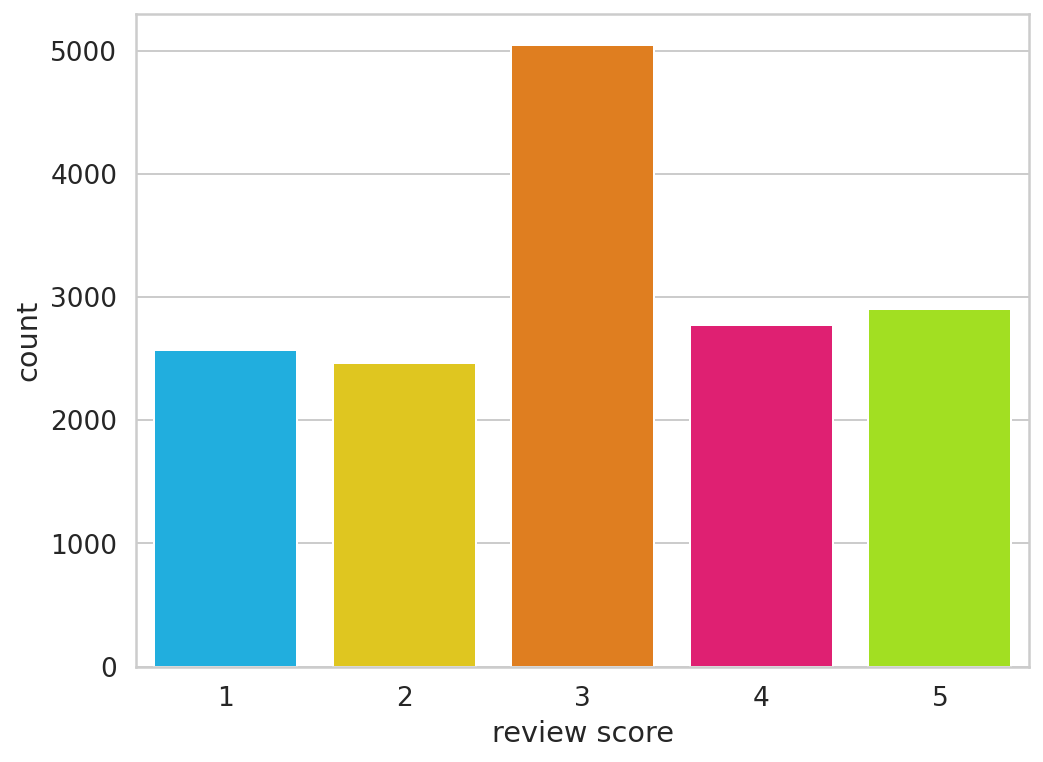

In [11]:
# распределение классов в выборке

sns.countplot(df.score)
plt.xlabel('review score');

Сбалансируем классы: 1 и 2 будут негативные; 3 - нейтральные; 4 и 5 - положительные.

In [12]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

In [13]:
class_names = ['negative', 'neutral', 'positive']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


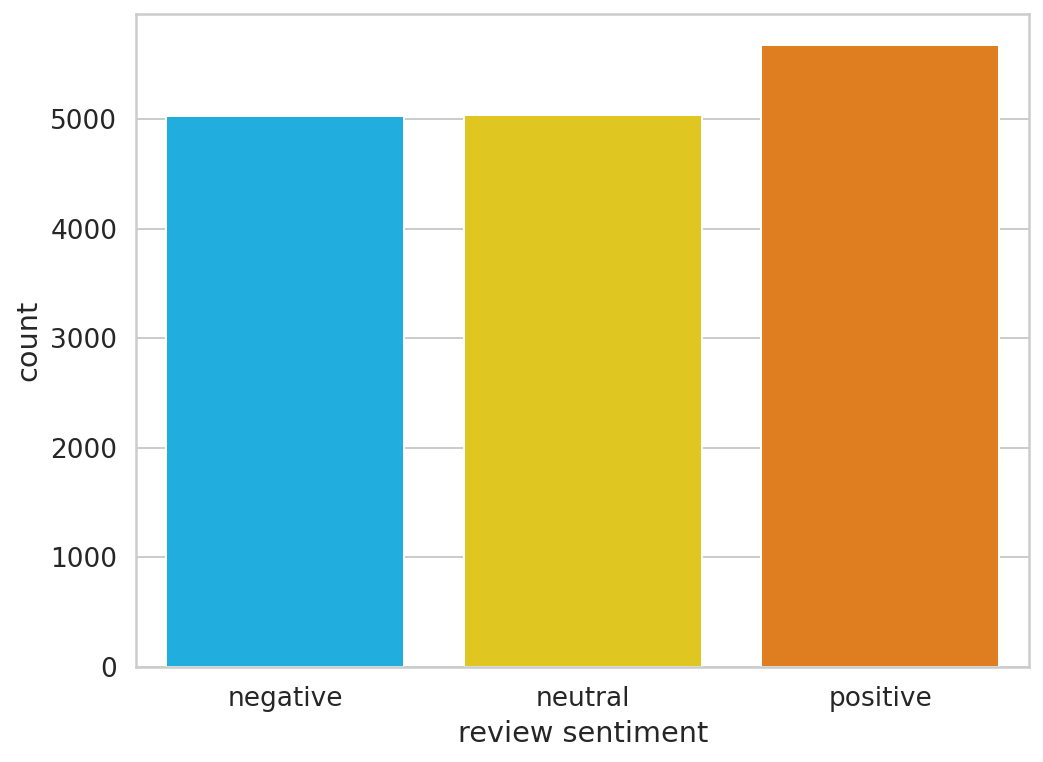

In [14]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

## Предобработка данных


Я взяла [bert-mini](https://huggingface.co/prajjwal1/bert-mini), она больше чем [bert-tiny](https://huggingface.co/prajjwal1/bert-tiny), но меньше [bert-small](https://huggingface.co/prajjwal1/bert-small). Весит модель немного (43 Мб), при этом показывает хорошие результаты. 

In [15]:
tokenizer = BertTokenizer.from_pretrained('prajjwal1/bert-mini')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/286 [00:00<?, ?B/s]

In [16]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=30,
  add_special_tokens=True, # Добавить '[CLS]' и '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Вернуть тензор PyTorch
  truncation=True
)
encoding

{'input_ids': tensor([[ 101, 2043, 2001, 1045, 2197, 2648, 1029, 1045, 2572, 5881, 2012, 2188,
         2005, 1016, 3134, 1012,  102,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0]])}

In [17]:
MAX_LEN = 160

In [46]:
class GPReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [47]:
RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [48]:
device

device(type='cuda', index=0)

In [49]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [50]:
df_train.shape, df_val.shape, df_test.shape

((14171, 12), (787, 12), (788, 12))

In [51]:
import warnings
warnings.filterwarnings('ignore')

In [52]:
BATCH_SIZE = 16

In [53]:
train_encodings = tokenizer(df_train['content'].to_list(), truncation=True, 
                            padding=True, return_token_type_ids=False, 
                            return_attention_mask=True, max_length=MAX_LEN
                            )
val_encodings = tokenizer(df_val['content'].to_list(), truncation=True, 
                          padding=True, return_token_type_ids=False,
                          return_attention_mask=True, max_length=MAX_LEN)
test_encodings = tokenizer(df_test['content'].to_list(), truncation=True, 
                           padding=True, return_token_type_ids=False,
                           return_attention_mask=True, max_length=MAX_LEN)

In [55]:
train_dataset = GPReviewDataset(train_encodings, df_train['sentiment'].to_list())
val_dataset = GPReviewDataset(val_encodings, df_val['sentiment'].to_list())
test_dataset = GPReviewDataset(test_encodings, df_test['sentiment'].to_list())

### Подсчет метрик

In [41]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

### Задаем гиперпараметры для модели

In [57]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


### Модель SentimentClassifier

In [58]:
from torch.nn import CrossEntropyLoss

In [62]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):

    super().__init__()
    self.bert = BertModel.from_pretrained('prajjwal1/bert-mini')
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_classes = n_classes
  
  def forward(self,        
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None
    ):

    last_hidden_state, pooled_output = self.bert(input_ids=input_ids,
                        attention_mask=attention_mask,
                        return_dict=False)

    output = self.drop(pooled_output)
    logits = self.out(output)

    loss = None
    if labels is not None:
        loss_fct = CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.n_classes), labels.view(-1))
    output = (logits,)
    return ((loss,) + output) if loss is not None else output

In [ ]:
first_model = SentimentClassifier(len(class_names))
first_model = first_model.to(device)

In [ ]:
trainer = Trainer(
    model=first_model,                        # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics = compute_metrics    # metrics to evaluate
)

trainer.train()

In [65]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 787
  Batch size = 16


{'epoch': 5.0,
 'eval_accuracy': 0.8030495552731893,
 'eval_f1': 0.8039476918270018,
 'eval_loss': 0.5884063839912415,
 'eval_precision': 0.8051720421742496,
 'eval_recall': 0.8030495552731893,
 'eval_runtime': 1.3013,
 'eval_samples_per_second': 604.765,
 'eval_steps_per_second': 38.422}

In [66]:
trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")

***** Running Evaluation *****
  Num examples = 788
  Batch size = 16


{'epoch': 5.0,
 'test_accuracy': 0.7918781725888325,
 'test_f1': 0.7940849711736423,
 'test_loss': 0.6536476612091064,
 'test_precision': 0.7999198162390393,
 'test_recall': 0.7918781725888325,
 'test_runtime': 1.3087,
 'test_samples_per_second': 602.118,
 'test_steps_per_second': 38.205}

### Bert with CLS

In [87]:
class SentimentClassifier_CLS(nn.Module):

  def __init__(self, n_classes):

    super().__init__()
    self.bert = BertModel.from_pretrained('prajjwal1/bert-mini')
    self.drop = nn.Dropout(p=0.3)
    self.linear = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size)
    self.out = nn.Linear(self.bert.config.hidden_size + 256, n_classes)
    self.n_classes = n_classes
  
  def forward(self,        
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None
    ):

    last_hidden_state, pooled_output = self.bert(
                                  input_ids=input_ids,
                                  attention_mask=attention_mask,
                                  return_dict=False)
    
    cls = last_hidden_state[:,0,:]
    pooled_output = self.linear(self.drop(pooled_output)) 
    stacked_layers = torch.hstack([cls, pooled_output])
    
    logits = self.out(stacked_layers)

    loss = None
    if labels is not None:
        loss_fct = CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.n_classes), labels.view(-1))
    output = (logits,)
    return ((loss,) + output) if loss is not None else output

In [ ]:
CLS_model = SentimentClassifier_CLS(len(class_names)) 
CLS_model = CLS_model.to(device)

In [ ]:
trainer = Trainer(
    model=CLS_model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics = compute_metrics    # metrics to evaluate
)

trainer.train()

In [90]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 787
  Batch size = 16


{'epoch': 5.0,
 'eval_accuracy': 0.8030495552731893,
 'eval_f1': 0.8030595175428799,
 'eval_loss': 0.557182252407074,
 'eval_precision': 0.8031532469251488,
 'eval_recall': 0.8030495552731893,
 'eval_runtime': 1.3717,
 'eval_samples_per_second': 573.747,
 'eval_steps_per_second': 36.452}

In [91]:
trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")

***** Running Evaluation *****
  Num examples = 788
  Batch size = 16


{'epoch': 5.0,
 'test_accuracy': 0.7944162436548223,
 'test_f1': 0.7955222562033141,
 'test_loss': 0.6536588072776794,
 'test_precision': 0.7981893277513755,
 'test_recall': 0.7944162436548223,
 'test_runtime': 1.3231,
 'test_samples_per_second': 595.559,
 'test_steps_per_second': 37.789}

### BertForSequenceClassification

In [ ]:
from transformers import BertForSequenceClassification
from transformers import BertConfig

bsc_model = BertForSequenceClassification.from_pretrained("prajjwal1/bert-mini")
bsc_model.to(device) 

config = BertConfig.from_pretrained("prajjwal1/bert-mini")
config.num_labels = len(class_names)

bsc_model = BertForSequenceClassification(config) 

In [ ]:
trainer = Trainer(
    model=bsc_model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics = compute_metrics    # metrics to evaluate
)

trainer.train()

In [94]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 787
  Batch size = 16


{'epoch': 5.0,
 'eval_accuracy': 0.7560355781448539,
 'eval_f1': 0.7585868349085885,
 'eval_loss': 0.6634552478790283,
 'eval_precision': 0.7630031167802682,
 'eval_recall': 0.7560355781448539,
 'eval_runtime': 1.2985,
 'eval_samples_per_second': 606.1,
 'eval_steps_per_second': 38.507}

In [95]:
trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")

***** Running Evaluation *****
  Num examples = 788
  Batch size = 16


{'epoch': 5.0,
 'test_accuracy': 0.700507614213198,
 'test_f1': 0.7056580488358142,
 'test_loss': 0.7588328123092651,
 'test_precision': 0.7177320942922065,
 'test_recall': 0.700507614213198,
 'test_runtime': 1.5382,
 'test_samples_per_second': 512.285,
 'test_steps_per_second': 32.505}

### Bert CLS-Pooled

In [96]:
class SentimentClassifier_CLSPooled(nn.Module):

  def __init__(self, n_classes):

    super().__init__()
    self.bert = BertModel.from_pretrained('prajjwal1/bert-mini')
    self.drop = nn.Dropout(p=0.3)
    self.linear = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size)
    self.out = nn.Linear(self.bert.config.hidden_size + 256, n_classes)
    self.n_classes = n_classes

  def forward(self,        
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None
    ):

    last_hidden_state, pooled_output, hidden_states = self.bert(
                                                  input_ids=input_ids,
                                                  attention_mask=attention_mask,
                                                  output_hidden_states=True,
                                                  return_dict=False)
    
    all_hidden_states = torch.stack(hidden_states)
    cls_embeddings = torch.mean(all_hidden_states[:, :, 0], 0)
    pooled_output = self.linear(self.drop(pooled_output))
    stacked_layers = torch.hstack([cls_embeddings, pooled_output])

    logits = self.out(stacked_layers)

    loss = None
    if labels is not None:
        loss_fct = CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.n_classes), labels.view(-1))
    output = (logits,)
    return ((loss,) + output) if loss is not None else output

In [ ]:
CLSpooled_model = SentimentClassifier_CLSPooled(len(class_names)) 
CLSpooled_model = CLSpooled_model.to(device)

In [ ]:
trainer = Trainer(
    model=CLSpooled_model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics = compute_metrics    # metrics to evaluate
)

trainer.train()

In [100]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 787
  Batch size = 16


{'epoch': 5.0,
 'eval_accuracy': 0.8106734434561627,
 'eval_f1': 0.8116346970764469,
 'eval_loss': 0.5946081280708313,
 'eval_precision': 0.8128942871422203,
 'eval_recall': 0.8106734434561627,
 'eval_runtime': 1.3383,
 'eval_samples_per_second': 588.039,
 'eval_steps_per_second': 37.36}

In [101]:
trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")

***** Running Evaluation *****
  Num examples = 788
  Batch size = 16


{'epoch': 5.0,
 'test_accuracy': 0.7842639593908629,
 'test_f1': 0.7846119864721932,
 'test_loss': 0.6908041834831238,
 'test_precision': 0.785630796169868,
 'test_recall': 0.7842639593908629,
 'test_runtime': 1.3426,
 'test_samples_per_second': 586.91,
 'test_steps_per_second': 37.24}

### Результаты моделей

Все модели показали сравнимые результаты, за исключением модели для классификации последовательности. Так как модель я взяла маленькую, результаты вполне ожидаемые и, я бы сказала, даже хорошие. Вероятно, на большей модели с большим кол-вом эпох результаты были бы отличные.


|Model|F1 evaluate|F1 test|
|-----|---|----|
|Bert-mini standart|0.80|0.79|
|TinyBert with CLS|0.80|0.79|
|Bert-mini on BertForSequenceClassification|0.75|0.70|
|Bert-mini with CLS-pooled|**0.81**|**0.78**|



### Проверка моделей на рандомных отзывах из google play

In [109]:
def check_text(text, model):
    encoding = tokenizer.encode_plus(
      text,
      max_length=MAX_LEN,
      add_special_tokens=True, 
      return_token_type_ids=True,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',  
      truncation=True
    ).to('cuda')
    result = model(input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'])[0].cpu().detach().numpy().argmax()
    return class_names[result]

In [104]:
# Отзыв на фильм "Титаник", 5 звезд
text_1 = """
I dont regret always see this movie at night. it astonished me when I first saw it. 
Witch is why I now like the ship. People who hate are just mad because they are the only ones who think it's disrespectful.
But no. It's just rose telling a story. And who every people say people like because of "the bed room part" well no. 
Probably all people like because it's interesting and sad. So people on you shame on you. You can't predict everything. 
And it's your opinion on the movie. That's a LIE!
"""

In [110]:
check_text(text_1, CLSpooled_model)

'negative'

In [113]:
check_text(text_1, first_model)

'negative'

In [114]:
check_text(text_1, bsc_model)

'negative'

In [115]:
check_text(text_1, CLS_model)

'negative'

Ни одна модель не выдала верного ответа (проверила на всех, стало интересно), скорее всего так происходит потому, что пользователь решил описать противоположное ему мнение...

In [111]:
# Отзыв на "The Matrix Resurrections", 2 звезды
text_2 = """
Barely worth the $6 I paid to see it in theaters. I'm a big Matrix fan. 
I grew up watching the films. While this one certainly has its moments, 
it's mostly unenthusiastic and filled with self congratulatory nonsense and seemingly intentionally cliche "Matrix" quips. 
But not everyone has the same opinion, it really just comes down to whether you want to spend the money to see it or not.
"""

In [116]:
check_text(text_2, CLSpooled_model)

'neutral'

In [117]:
check_text(text_2, first_model)

'positive'

In [118]:
check_text(text_2, bsc_model)

'neutral'

In [119]:
check_text(text_2, CLS_model)

'negative'

А тут угадала модель с CLS токенами, остальные были близко, но все же неверно предсказали.

In [120]:
# Отзыв на "The Wolf of Wall Street", 3 звезды
text_3 = """
Where's the story? While providing glimpses of greatness, this film felt like a string of captured awkward moments rather than a story. 
It could have excelled if one of the editors could have slapped some sense into Scorsese and dropped 35 - 40 minutes off the agonizing 
three hours of pointless dialog and over-the-top debauchery. I liked DiCaprio's first go around with this character in Catch Me If You Can. 
At least in that offering I cared what happened to him, rather than despised him for wasting my time.
"""

In [121]:
check_text(text_3, CLSpooled_model)

'negative'

In [122]:
check_text(text_3, first_model)

'negative'

In [123]:
check_text(text_3, bsc_model)

'neutral'

In [124]:
check_text(text_3, CLS_model)

'negative'

Здесь лучше всех угадала модель для классификации последовательности, хотя текст отзыва все-таки тянет на негативный, как мне показалось.

### Мои выводы насчет моделей после тестирования на рандомных отзывах:
Мне кажется, что люди сами могут ошибаться с "классификацией" своего отзыва -- поставить, например, 3/5, при этом очень красочно описав минусы товара. В целом задача усложняется с большим дроблением классов, поэтому, разделив отзывы на негативные/положительные, скорее всего, при таких классах модели лучше бы справились с задачей (потому что проблема может быть опять же в изначальной разметке отзывов).

Кстати, как однажды мне сказали сотрудники одного магазина, люди чаще и более подробно описывают свое недовольство товаром, чем когда их все устраивает :)